In [13]:
import os
import time
from google.cloud import documentai_v1beta3 as documentai
from google.cloud import storage
from google.api_core.client_options import ClientOptions

In [16]:
# --------------- CONFIGURATION -------------------
PROJECT_ID = "prj-app-wh-dev"
LOCATION = "us"  # or "eu" depending on your processor location

PROCESSOR_ID = 'c40985ae7a77f2e2'



**Create Processor**

In [17]:
def create_processor(client, display_name):
    parent = f"projects/{PROJECT_ID}/locations/{LOCATION}"
    processor = documentai.Processor(
        type_="CUSTOM_EXTRACTION_PROCESSOR",  # Very important
        display_name=display_name,
    )
    response = client.create_processor(parent=parent, processor=processor)
    print(f"Processor created: {response.name}")
    return response.name


client = documentai.DocumentProcessorServiceClient()
processor_name = create_processor(client, display_name="automation_test_processor")
processor_id = processor_name.split("/")[-1]



AlreadyExists: 409 A Processor with the name 'automation_test_processor' already exists. [reason: "PROCESSOR_DUPLICATE_NAME"
domain: "documentai.googleapis.com"
metadata {
  key: "display_name"
  value: "automation_test_processor"
}
]

**Initialize Dataset**

In [19]:
# from google.cloud import documentai_v1beta3 as documentai
# from google.api_core.client_options import ClientOptions

gcs_uri_prefix = "gs://prj-app-wh-dev-backend-data/docai_dataset/"

# Setup the endpoint correctly
client_options = ClientOptions(api_endpoint=f"{LOCATION}-documentai.googleapis.com")

# Initialize the Document AI client
client = documentai.DocumentServiceAsyncClient(client_options=client_options)

# Build the full dataset resource name
dataset_name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}/dataset"

# Prepare the dataset configuration
dataset = documentai.Dataset(
    name=dataset_name,
    gcs_managed_config=documentai.Dataset.GCSManagedConfig(
        gcs_prefix=documentai.GcsPrefix(
            gcs_uri_prefix=gcs_uri_prefix
        )
    ),
    spanner_indexing_config=documentai.Dataset.SpannerIndexingConfig()
)

# Prepare the update request
update_request = documentai.UpdateDatasetRequest(
    dataset=dataset
)

# Call the update_dataset API
operation = client.update_dataset(request=update_request)

response = (await operation).result()



**Create Schema**

In [20]:
from google.cloud import documentai_v1beta3 as documentai
from google.protobuf import field_mask_pb2

# ✅ Use the DocumentServiceClient
client = documentai.DocumentServiceClient()

# Dataset name
dataset_name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}/dataset"
dataset_schema_name = f"{dataset_name}/datasetSchema"

# Define the schema fields with all data types
properties_list = [
    documentai.DocumentSchema.EntityType.Property(
        name="invoice_number",
        display_name="Invoice Number",
        value_type="string",  # Plain text
        occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.OPTIONAL_ONCE,
    ),
    documentai.DocumentSchema.EntityType.Property(
        name="item_count",
        display_name="Item Count",
        value_type="number",  # Number
        occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.OPTIONAL_ONCE,
    ),
    documentai.DocumentSchema.EntityType.Property(
        name="total_amount",
        display_name="Total Amount",
        value_type="currency",  # Currency
        occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.OPTIONAL_ONCE,
    ),
    documentai.DocumentSchema.EntityType.Property(
        name="line_item_amount",
        display_name="Line Item Amount",
        value_type="money",  # Money
        occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.OPTIONAL_MULTIPLE,
    ),
    documentai.DocumentSchema.EntityType.Property(
        name="invoice_date",
        display_name="Invoice Date",
        value_type="datetime",  # Datetime
        occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.REQUIRED_ONCE,
    ),
    documentai.DocumentSchema.EntityType.Property(
        name="billing_address",
        display_name="Billing Address",
        value_type="address",  # Address
        occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.OPTIONAL_ONCE,
    ),
    documentai.DocumentSchema.EntityType.Property(
        name="is_paid",
        display_name="Is Paid",
        value_type="boolean",  # Checkbox
        occurrence_type=documentai.DocumentSchema.EntityType.Property.OccurrenceType.OPTIONAL_ONCE,
    ),
]

# Create the DocumentSchema - ✅ name must be 'custom_extraction_document_type'
document_schema = documentai.DocumentSchema(
    display_name="Invoice Schema (All Data Types)",
    description="Schema demonstrating all supported data types",
    entity_types=[
        documentai.DocumentSchema.EntityType(
            display_name="Invoice",
            name="custom_extraction_document_type",
            description="Root type for invoice fields",
            base_types=["document"],
            properties=properties_list
        )
    ]
)

# Build the dataset schema
dataset_schema = documentai.DatasetSchema(
    name=dataset_schema_name,
    document_schema=document_schema
)

# Prepare the request
update_schema_request = documentai.UpdateDatasetSchemaRequest(
    dataset_schema=dataset_schema,
    update_mask=field_mask_pb2.FieldMask(paths=["document_schema"])
)

# ✅ Update the dataset schema using DocumentServiceClient
response = client.update_dataset_schema(request=update_schema_request)
print("✅ Dataset schema updated with all data types:", response)


✅ Dataset schema updated with all data types: name: "projects/prj-app-wh-dev/locations/us/processors/c40985ae7a77f2e2/dataset/datasetSchema"
document_schema {
  display_name: "Invoice Schema (All Data Types)"
  description: "Schema demonstrating all supported data types"
  entity_types {
    name: "custom_extraction_document_type"
    base_types: "document"
    properties {
      name: "invoice_number"
      value_type: "string"
      occurrence_type: OPTIONAL_ONCE
      property_metadata {
      }
      display_name: "Invoice Number"
    }
    properties {
      name: "item_count"
      value_type: "number"
      occurrence_type: OPTIONAL_ONCE
      property_metadata {
      }
      display_name: "Item Count"
    }
    properties {
      name: "total_amount"
      value_type: "currency"
      occurrence_type: OPTIONAL_ONCE
      property_metadata {
      }
      display_name: "Total Amount"
    }
    properties {
      name: "line_item_amount"
      value_type: "money"
      occurrenc

/tmp/ipykernel_199817/60417930.py:85: RuntimeWarning: coroutine 'AsyncFuture.result' was never awaited
  response = client.update_dataset_schema(request=update_schema_request)


**Initial parsing of samples by Document AI pretrained model for JSON creation**

In [23]:
from google.cloud import documentai_v1beta3 as documentai
from google.protobuf.json_format import MessageToDict
import json


client = documentai.DocumentProcessorServiceClient()

name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}"

gcs_input_uri = "gs://prj-app-wh-dev-backend-data/docai_dataset/train/invoice1.pdf"

# ✅ Just one GcsDocument directly
gcs_document = documentai.GcsDocument(
    gcs_uri=gcs_input_uri,
    mime_type="application/pdf"
)

# ✅ Create the request (note we now use gcs_document ✅)
request = documentai.ProcessRequest(
    name=name,
    skip_human_review=True,
    gcs_document=gcs_document
)




# 🚀 Process the document
result = client.process_document(request=request)
print("✅ Processed document:", result.document)

print(type(result.document))


# ✅ Access the internal protobuf directly
document_proto = result._pb.document

# Convert to dict
document_dict = MessageToDict(document_proto)

# ✅ Manually set the URI (IMPORTANT!)
document_dict["uri"] = gcs_input_uri  

# ✅ Wrap it in the expected format
wrapped_document = {
    "document": document_dict
}

# ✅ Save to file
with open("invoice1.json", "w") as f:
    json.dump(wrapped_document, f, indent=2)

print("✅ Saved JSON to invoice1.json")

✅ Processed document: uri: ""
mime_type: "application/pdf"
text: "Systems\nTalenom Online\nPayments\nTalenom Online user fee\nEUR 9.90 per user per month\nReceipt and payment\nOnline Lite user fee\nEUR 3.90 per user per month\nE-invoices\nEUR 0.59 each\nPaper invoices\nEUR 1.59 each\nSales invoices\nEmail invoices\nEUR 1.59 each\nInvoice submission service, e-invoice and e-mail invoice\nManually entered invoices\nEUR 0.59 each\n1-499 invoices/month\nEUR 0.59 each\nTravel expense claims, Talenom mobile app\nEUR 1.80 each\n500-999 invoices/month\nEUR 0.45 each\nPayments to payees outside SEPA\n1000-1999 invoices/month\nEUR 0.35 each\nor in currencies other than the euro\nEUR 5.90 each\n2 000-3 999 invoices/month\nEUR 0.32 each\nProcessing in the event of insufficient funds\nEUR 15.00 each\n4 000 or more invoices per month\nEUR 0.29 each\nTalenom Business Intelligence Pro\nInvoice submission service, paper invoice\nService deployment fee\nEUR 3 000.00\n1-499 invoices/month\nEUR 2.49 each\

In [4]:
from google.protobuf.json_format import MessageToJson
import json

client = documentai.DocumentProcessorServiceClient()

name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}"
gcs_input_uri = "gs://prj-app-wh-dev-backend-data/docai_dataset/train/invoice1.pdf"

# ✅ Process the document
gcs_document = documentai.GcsDocument(
    gcs_uri=gcs_input_uri,
    mime_type="application/pdf"
)

request = documentai.ProcessRequest(
    name=name,
    skip_human_review=True,
    gcs_document=gcs_document
)

result = client.process_document(request=request)
print("✅ Processed document")

# ✅ Get the proto object
proto_document = result.document._pb

# ✅ Serialize to JSON string (the *official* Google format)
document_json_str = MessageToJson(proto_document, preserving_proto_field_name=True)

# ✅ Convert JSON string to a Python dict
document_dict = json.loads(document_json_str)

# ✅ Patch in the URI manually (since it's missing)
document_dict["uri"] = gcs_input_uri

# ✅ Save to file in the expected format: { "document": { ... } }
final_json = {
    "document": document_dict
}

with open("invoice1.json", "w") as f:
    json.dump(final_json, f, indent=2)

print("✅ Saved JSON to invoice1.json (with URI patched)")


✅ Processed document
✅ Saved JSON to invoice1.json (with URI patched)


**Import documents in DocAI processor**

In [ ]:
from google.cloud import documentai_v1beta3 as documentai

client = documentai.DocumentServiceClient()

dataset_name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}/dataset"

gcs_documents = documentai.GcsDocuments(
    documents=[
        documentai.GcsDocument(
            gcs_uri="gs://prj-app-wh-dev-backend-data/docai_dataset/train/invoice1.json",
            mime_type="application/json"
        )
    ]
)

batch_input_config = documentai.BatchDocumentsInputConfig(
    gcs_documents=gcs_documents
)

batch_import_config = documentai.ImportDocumentsRequest.BatchDocumentsImportConfig(
    batch_input_config=batch_input_config,
    dataset_split=documentai.DatasetSplitType.DATASET_SPLIT_TRAIN
)

request = documentai.ImportDocumentsRequest(
    dataset=dataset_name,
    batch_documents_import_configs=[batch_import_config]
)

operation = client.import_documents(request=request)
print("✅ Importing documents...")
response = operation.result()
print("✅ Documents imported:", response)


✅ Importing documents...


InvalidArgument: 400 Failed to import all documents. 3: Failed to import all documents.

In [26]:
from google.cloud import documentai_v1beta3 as documentai
from google.api_core.client_options import ClientOptions

# Make sure LOCATION is set correctly (e.g., 'us', 'eu')
client_options = ClientOptions(api_endpoint=f"{LOCATION}-documentai.googleapis.com")
client = documentai.DocumentServiceClient(client_options=client_options)

dataset_name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}/dataset"

gcs_documents = documentai.GcsDocuments(
    documents=[
        documentai.GcsDocument(
            gcs_uri="gs://prj-app-wh-dev-backend-data/docai_samples/invoice1.pdf",
            mime_type="application/pdf"
        )
    ]
)

batch_input_config = documentai.BatchDocumentsInputConfig(
    gcs_documents=gcs_documents
)

batch_import_config = documentai.ImportDocumentsRequest.BatchDocumentsImportConfig(
    batch_input_config=batch_input_config,
    dataset_split=documentai.DatasetSplitType.DATASET_SPLIT_TRAIN
)

request = documentai.ImportDocumentsRequest(
    dataset=dataset_name,
    batch_documents_import_configs=[batch_import_config]
)

operation = client.import_documents(request=request)
print("✅ Importing documents...")
response = operation.result()
print("✅ Documents imported:", response)


✅ Importing documents...


TypeError: Could not convert Any to ImportDocumentsResponse

**Visualizing the annotations**

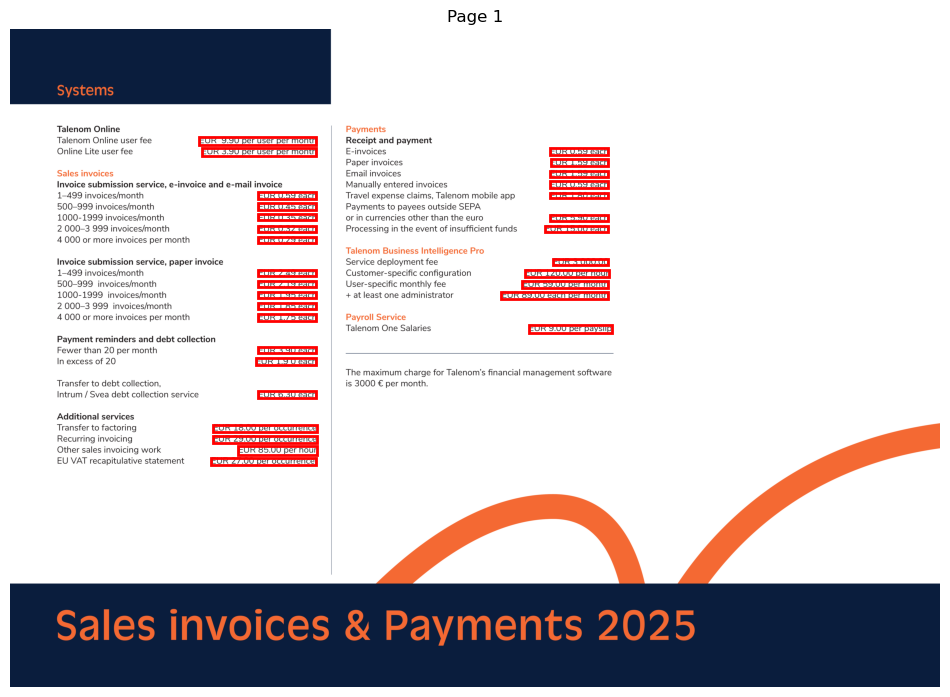

In [14]:
import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pdf2image import convert_from_path
from google.cloud import documentai_v1beta3 as documentai

# -------------------------------
# 🔹 Step 1: Convert PDF to images
# -------------------------------

pdf_path = "dataset_samples/invoice1.pdf"  # Local path to your PDF
pages = convert_from_path(pdf_path, dpi=600)

# -------------------------------
# 🔹 Step 2: Get the document response
# -------------------------------

document = result.document  # The same result from your previous process

# -------------------------------
# 🔹 Step 3: Plot each page with bounding boxes ONLY
# -------------------------------

for page_index, page in enumerate(document.pages):
    img = pages[page_index]
    fig, ax = plt.subplots(figsize=(12, 16))
    ax.imshow(img)

    # Loop through entities and draw boxes
    for entity in document.entities:
        for page_ref in entity.page_anchor.page_refs:
            if page_ref.page != page_index:
                continue  # Skip if not the same page

            # Get bounding box (normalized)
            bbox = page_ref.bounding_poly.normalized_vertices
            x_vals = [v.x for v in bbox]
            y_vals = [v.y for v in bbox]

            min_x = min(x_vals) * img.width
            min_y = min(y_vals) * img.height
            width = (max(x_vals) - min(x_vals)) * img.width
            height = (max(y_vals) - min(y_vals)) * img.height

            # Draw rectangle only (no label)
            rect = Rectangle(
                (min_x, min_y), width, height,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)

    ax.set_title(f"Page {page_index + 1}")
    plt.axis('off')
    plt.show()
